In [1]:
import numpy as np
import pandas
import scanpy as sc
import anndata
import json
import matplotlib.pyplot as plt
import scvelo as scv
import os

%matplotlib inline

/home/picrin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Dimensionality reduction and stemness analysis 

We've already pre-processed our data, and are ready to begin analysis. One of the first challenges is the very high dimensionality of our dataset. It's difficult to search for patterns when we can't easily "see" or "interact" with our data, and high dimensionality is a hindrance, with potentially thousands of plots that would have to be anlaysed and reasoned about. A common technique to solve this problem is dimensionality reduction, which can be either linear (preserve angles and distances in the original space, carrying out minimally lossy projection onto the reduced 2d or 3d space; e.g. PCA) or non-linear ("roughly" preserving angles and distances at least in a global sense, but with more adventurous characterics locally, e.g.)

In [2]:
adata = anndata.read_h5ad(os.path.join("data", "01_bile_duct_cancer.h5ad"))

In [3]:
adata

AnnData object with n_obs × n_vars = 1937 × 1784 
    obs: 'n_counts', 'percent_mito', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'before_filter_nonvariable_genes', 'before_filter_rare_genes'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [4]:
sc.tl.pca(adata, svd_solver='arpack')

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

In [5]:
liver_specific = """CD45
CD24
CD133
CD13
CD90/Thy1
Aminopeptidase N/CD13
SOX2
Nanog
SALL4""".split("\n")

In [6]:
liver_specific

['CD45',
 'CD24',
 'CD133',
 'CD13',
 'CD90/Thy1',
 'Aminopeptidase N/CD13',
 'SOX2',
 'Nanog',
 'SALL4']

In [7]:
#post_filtered_genes = set(adata.var.values.T[0])

In [8]:
#for g in liver_specific:
#    print(g, g in gene_names)

In [9]:
#len(gene_names)

In [10]:
#with open("gene_names", "w") as f:
#    for gene in gene_names:
#        f.write(gene)
#        f.write("\n")

In [11]:
#for g in liver_specific:
#    print(g in post_filtered_genes)

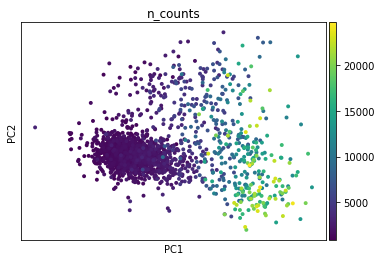

In [12]:
sc.pl.pca(adata, color='n_counts')

In [13]:
adata.X

array([[-0.5434749 , -0.22103214, -0.2742608 , ..., -0.45052046,
        -0.47658274,  0.53594697],
       [ 1.5705233 , -0.22103214, -0.2742608 , ...,  1.968441  ,
         1.7960523 , -1.4107459 ],
       [ 0.98178047,  1.213293  , -0.2742608 , ...,  0.35419247,
         0.27945194,  0.7284446 ],
       ...,
       [-0.5434749 , -0.22103214, -0.2742608 , ..., -0.45052046,
        -0.47658274, -0.00449344],
       [-0.5434749 , -0.22103214, -0.2742608 , ..., -0.45052046,
        -0.47658274, -1.4107459 ],
       [-0.5434749 , -0.22103214, -0.2742608 , ..., -0.45052046,
        -0.47658274,  0.42111808]], dtype=float32)

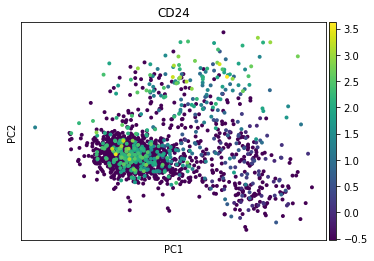

In [14]:
sc.pl.pca(adata, color='CD24')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

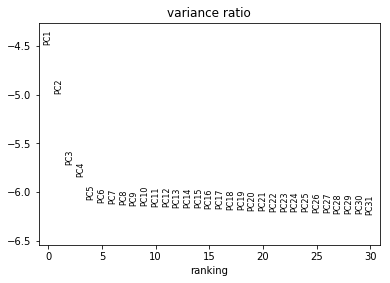

In [15]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [16]:
adata

AnnData object with n_obs × n_vars = 1937 × 1784 
    obs: 'n_counts', 'percent_mito', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'before_filter_nonvariable_genes', 'before_filter_rare_genes', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [17]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

## Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [18]:
sc.tl.umap(adata)

In [19]:
"TGFB1" in adata.var_names

False

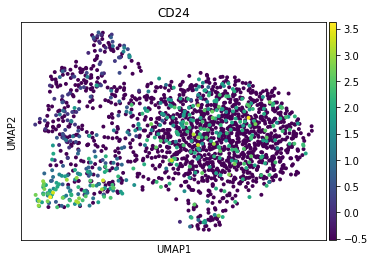

In [20]:
sc.pl.umap(adata, color=["CD24"])

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

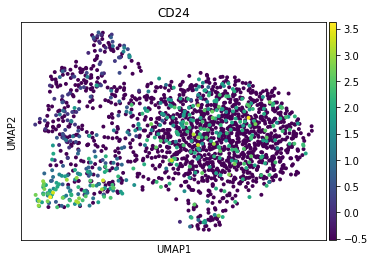

In [21]:
sc.pl.umap(adata, color=['CD24'], use_raw=False)

## Clustering the neighborhood graph

As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine et al. (2015)](https://doi.org/10.1016/j.cell.2015.05.047). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [22]:
sc.tl.louvain(adata)

Plot the clusters, which agree quite well with the result of Seurat.

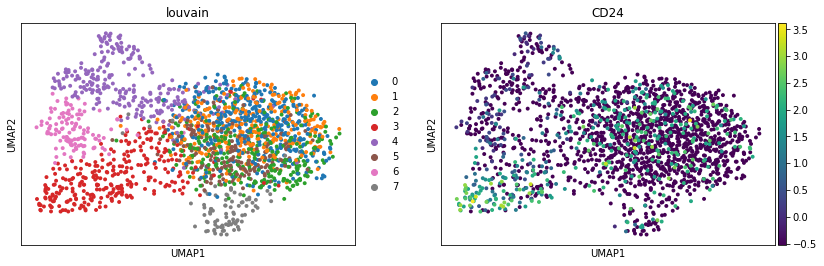

In [23]:
sc.pl.umap(adata, color=['louvain', 'CD24'])

Save the result.

# Compute velocity

In [24]:
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00.67) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00.22) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00.24) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00.55) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [25]:
scv.tl.velocity_embedding(adata, basis='umap')

computing velocity embedding
    finished (0:00:00.34) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

computing velocity embedding
    finished (0:00:00.37) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

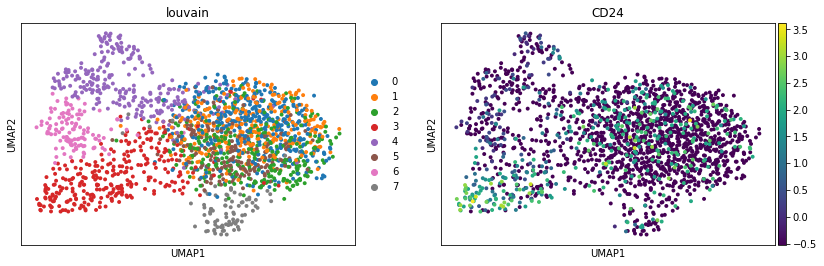

In [26]:
scv.tl.velocity_embedding(adata, basis='umap')
sc.pl.umap(adata, color=['louvain', 'CD24'])

<Figure size 432x288 with 0 Axes>

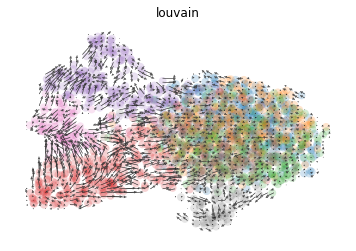

In [27]:
scv.pl.velocity_embedding_grid(adata, basis='umap', arrow_length=3, arrow_size=1.3)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

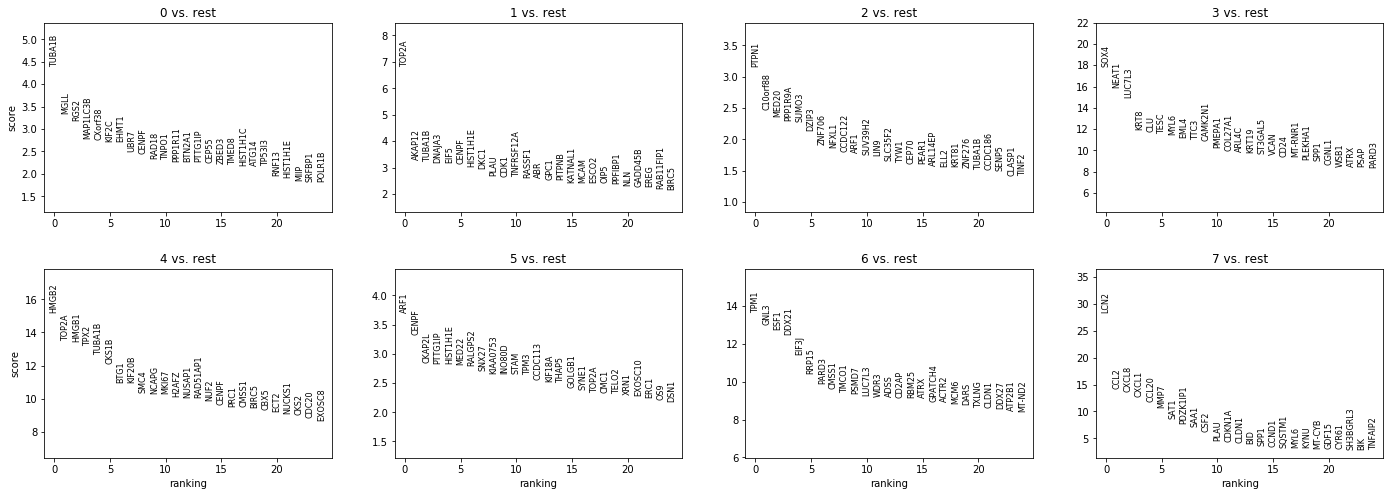

In [28]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [29]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:00.25)


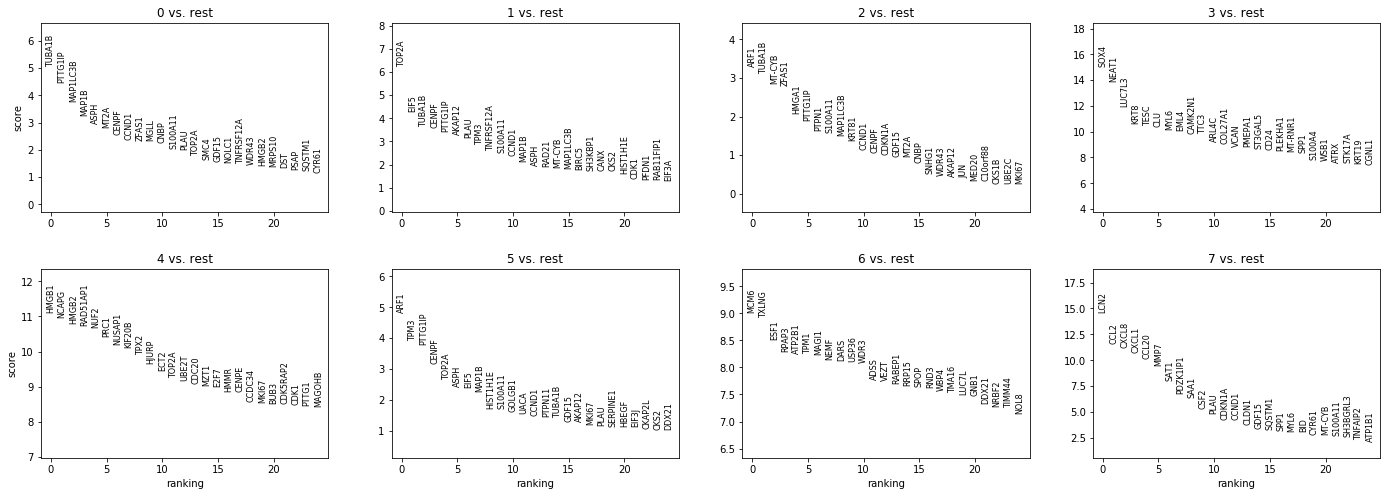

In [30]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [31]:
adata.write(results_file)

NameError: name 'results_file' is not defined

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [ ]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

Get a table with the scores and groups.

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

Compare to a single cluster. 

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object that computed differential expression by comparing to the rest of the groups.

In [ ]:
adata = sc.read(results_file)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')

Actually mark the cell types.

In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A+ Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)

In [ ]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

In [ ]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain')

There is also a very compact violin plot.

In [ ]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)

During the course of this analysis, the AnnData accumlated the following annotations.

In [ ]:
adata

In [ ]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations.

In [ ]:
adata.X = None
adata.write('./write/pbmc3k_withoutX.h5ad', compression='gzip')

If you want to export to "csv", you have the following options:

In [ ]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )